In [1]:
!python3 -c 'import tensorrt; print("TensorRT version: {}".format(tensorrt.__version__))'


TensorRT version: 8.0.1.6


In [2]:
from PIL import Image
from io import BytesIO
import requests

output_image="input.ppm"

# Read sample image input and save it in ppm format
print("Exporting ppm image {}".format(output_image))
response = requests.get("https://pytorch.org/assets/images/deeplab1.png")
with Image.open(BytesIO(response.content)) as img:
    ppm = Image.new("RGB", img.size, (255, 255, 255))
    ppm.paste(img, mask=img.split()[3])
    ppm.save(output_image)

Exporting ppm image input.ppm


In [3]:
import numpy as np
import os
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt

import matplotlib.pyplot as plt
from PIL import Image

TRT_LOGGER = trt.Logger()

# Filenames of TensorRT plan file and input/output images.
engine_file = "fcn-resnet101.engine"
input_file  = "input.ppm"
output_file = "output.ppm"

In [4]:
# For torchvision models, input images are loaded in to a range of [0, 1] and
# normalized using mean = [0.485, 0.456, 0.406] and stddev = [0.229, 0.224, 0.225].
def preprocess(image):
    # Mean normalization
    mean = np.array([0.485, 0.456, 0.406]).astype('float32')
    stddev = np.array([0.229, 0.224, 0.225]).astype('float32')
    data = (np.asarray(image).astype('float32') / float(255.0) - mean) / stddev
    # Switch from HWC to to CHW order
    return np.moveaxis(data, 2, 0)

def postprocess(data):
    num_classes = 21
    # create a color palette, selecting a color for each class
    palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = np.array([palette*i%255 for i in range(num_classes)]).astype("uint8")
    # plot the segmentation predictions for 21 classes in different colors
    img = Image.fromarray(data.astype('uint8'), mode='P')
    img.putpalette(colors)
    return img

In [5]:
def load_engine(engine_file_path):
    assert os.path.exists(engine_file_path)
    print("Reading engine from file {}".format(engine_file_path))
    with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

In [6]:
def infer(engine, input_file, output_file):
    print("Reading input image from file {}".format(input_file))
    with Image.open(input_file) as img:
        input_image = preprocess(img)
        image_width = img.width
        image_height = img.height

    with engine.create_execution_context() as context:
        # Set input shape based on image dimensions for inference
        context.set_binding_shape(engine.get_binding_index("input"), (1, 3, image_height, image_width))
        # Allocate host and device buffers
        bindings = []
        for binding in engine:
            binding_idx = engine.get_binding_index(binding)
            size = trt.volume(context.get_binding_shape(binding_idx))
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            if engine.binding_is_input(binding):
                input_buffer = np.ascontiguousarray(input_image)
                input_memory = cuda.mem_alloc(input_image.nbytes)
                bindings.append(int(input_memory))
            else:
                output_buffer = cuda.pagelocked_empty(size, dtype)
                output_memory = cuda.mem_alloc(output_buffer.nbytes)
                bindings.append(int(output_memory))

        stream = cuda.Stream()
        # Transfer input data to the GPU.
        cuda.memcpy_htod_async(input_memory, input_buffer, stream)
        # Run inference
        context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
        # Transfer prediction output from the GPU.
        cuda.memcpy_dtoh_async(output_buffer, output_memory, stream)
        # Synchronize the stream
        stream.synchronize()

    with postprocess(np.reshape(output_buffer, (image_height, image_width))) as img:
        print("Writing output image to file {}".format(output_file))
        img.convert('RGB').save(output_file, "PPM")

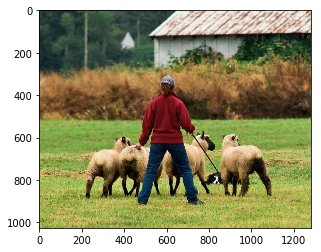

In [7]:
plt.imshow(Image.open("input.ppm"))


In [9]:
print("Running TensorRT inference for FCN-ResNet101")
with load_engine("/home/nvidia/SSD/Leandro_Intern/SparseInst/engine.trt") as engine:
    infer(engine, input_file, output_file)

Running TensorRT inference for FCN-ResNet101
Reading engine from file /home/nvidia/SSD/Leandro_Intern/SparseInst/engine.trt
Reading input image from file input.ppm


ValueError: cannot reshape array of size 40960000 into shape (1026,1282)